# 3c Lasso and Ridge Linear Regression with Cross-validation


## This notebook is identical in structure to 3b, the only difference being that this employs **_Polynomial Features_** 


#### This notebook has four main sections

## A. Imports, data shaping, and preprocessing
## B. Lasso CV regression on all features
## C. Lasso and Ridge regression on all features except `rating_count`
## D. Lasso and Ridge regression on all features except rating count but with also `budget` added as a feature

# A. Imports and data shaping

In [1]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
#director = 'godard'
director = 'hitchcock'
#director = 'bergman'
#director = 'fassbinder'
#director = 'herzog'
#director = 'allen'
#director='herzog'

In [3]:

pd.options.display.float_format = "{:,.5f}".format

In [4]:

dir_str = director + '/'

films_filename = 'films_to_analyze_' + director +'.pickle'
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [5]:
films_to_analyze.head(100)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
1,The Image Book,"2,018.00000",25 January 2019 (USA),84.00000,84.00000,NaN,"132,015.00000","132,015.00000",NaN,6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Ponts de Sarajevo,"2,014.00000",16 July 2014 (France),114.00000,114.00000,"2,100,000.00000",NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Goodbye to Language,"2,014.00000",28 May 2014 (France),70.00000,70.00000,NaN,"566,423.00000","566,423.00000",NaN,5.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,3x3D,"2,013.00000",30 April 2014 (France),70.00000,70.00000,NaN,NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Film socialisme,"2,010.00000",19 May 2010 (France),102.00000,102.00000,NaN,"222,079.00000","222,079.00000",NaN,5.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
17,Notre musique,"2,004.00000",19 May 2004 (France),80.00000,80.00000,NaN,"293,681.00000","293,681.00000",NaN,6.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
19,Ten Minutes Older: The Cello,"2,002.00000",26 June 2003 (Germany),146.00000,95.00000,NaN,"14,378.00000","14,378.00000",NaN,6.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
22,Éloge de l'amour,"2,001.00000",16 May 2001 (France),97.00000,97.00000,NaN,"503,548.00000","503,548.00000",NaN,6.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
28,For Ever Mozart,"1,996.00000",4 July 1997 (USA),84.00000,84.00000,NaN,"25,000.00000","25,000.00000",NaN,6.30000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
32,JLG/JLG - autoportrait de décembre,"1,994.00000",8 March 1995 (France),62.00000,62.00000,NaN,NaN,NaN,NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [6]:
prevalent_actors_filename  = 'prevalent_actors_' + director +'.pickle'
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [7]:
prevalent_actor_columns

Index(['Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto', 'Myriem Roussel', 'Jean-Pierre Cassel',
       'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [8]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [9]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [10]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [11]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
1,The Image Book,"2,018.00000",25 January 2019 (USA),84.00000,84.00000,NaN,"132,015.00000","132,015.00000",NaN,6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Ponts de Sarajevo,"2,014.00000",16 July 2014 (France),114.00000,114.00000,"2,100,000.00000",NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Goodbye to Language,"2,014.00000",28 May 2014 (France),70.00000,70.00000,NaN,"566,423.00000","566,423.00000",NaN,5.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,3x3D,"2,013.00000",30 April 2014 (France),70.00000,70.00000,NaN,NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Film socialisme,"2,010.00000",19 May 2010 (France),102.00000,102.00000,NaN,"222,079.00000","222,079.00000",NaN,5.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [12]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [13]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Jean-Luc Godard,Anna Karina,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
1,The Image Book,"2,018.00000",84.00000,Fabrice Aragno,0.00000,0.00000,6.20000,"2,314.00000",1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Ponts de Sarajevo,"2,014.00000",114.00000,Julian Atanassov,0.00000,0.00000,5.80000,319.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Goodbye to Language,"2,014.00000",70.00000,Fabrice Aragno,0.00000,0.00000,5.90000,"5,487.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,3x3D,"2,013.00000",70.00000,Luís Branquinho,0.00000,0.00000,5.80000,313.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Film socialisme,"2,010.00000",102.00000,Fabrice Aragno,0.00000,0.00000,5.70000,"2,539.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [14]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [15]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [16]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Jean-Luc Godard', 'Anna Karina',
       'Anne-Marie Miéville', 'Anne Wiazemsky', 'Jean-Pierre Léaud',
       'László Szabó', 'Jean-Claude Brialy', 'Jean-Paul Belmondo',
       'André S. Labarthe', 'Juliet Berto', 'Myriem Roussel',
       'Jean-Pierre Cassel', 'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [17]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [18]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

In [19]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [20]:
y.isnull().values.any()

False

### Train-val vs. test split

In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [22]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Jean-Luc Godard,Anna Karina,Anne-Marie Miéville,Anne Wiazemsky,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
1,"2,018.00000",84.00000,Fabrice Aragno,0.00000,0.00000,"2,314.00000",1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
17,"2,004.00000",80.00000,Julien Hirsch,0.00000,0.00000,"2,814.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
89,"1,969.00000",102.00000,OTHER,0.00000,0.00000,663.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
40,"1,991.00000",62.00000,OTHER,0.00000,0.00000,641.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
106,"1,965.00000",110.00000,Raoul Coutard,0.00000,0.00000,"29,534.00000",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
116,"1,963.00000",122.00000,OTHER,0.00000,0.00000,"1,641.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
96,"1,967.00000",105.00000,Raoul Coutard,0.00000,0.00000,"13,124.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75,"1,976.00000",100.00000,OTHER,1.00000,1.00000,55.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
108,"1,965.00000",99.00000,Raoul Coutard,0.00000,0.00000,"22,968.00000",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
38,"1,991.00000",110.00000,OTHER,0.00000,0.00000,95.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [23]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [24]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [25]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Caroline Champetier',
       'cinematographer_Fabrice Aragno',
       'cinematographer_Jean-Luc Godard', 'cinematographer_Julien Hirsch',
       'cinematographer_OTHER', 'cinematographer_Raoul Coutard',
       'cinematographer_William Lubtchansky'], dtype=object)

In [26]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,cinematographer_Raoul Coutard,cinematographer_William Lubtchansky
93,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
85,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
28,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
53,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
19,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000


Repeating transformations on testing set

In [27]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [28]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
93,"1,968.00000",100.00000,"2,791.00000"
85,"1,970.00000",95.00000,556.00000
28,"1,996.00000",84.00000,934.00000
53,"1,987.00000",90.00000,"1,204.00000"
19,"2,002.00000",146.00000,"1,663.00000"


#### Generate log and polynomials

In [29]:
#X_train_val_cont_poly.head()

In [30]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-30-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-30-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-30-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [31]:
X_test_cont.shape[0]

12

#### Concatenate columns

In [32]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [33]:
X_test_cat_df.isnull().values.any()

False

In [34]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [35]:
X_test_cat_df.shape

(12, 16)

In [36]:
X_train_val_combo.isnull().values.any()

False

In [37]:
X_test_combo.isnull().values.any()

False

In [38]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
0,"2,018.00000",84.00000,"2,314.00000",7.60986,7.74673,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"2,004.00000",80.00000,"2,814.00000",7.60290,7.94236,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"1,969.00000",102.00000,663.00000,7.58528,6.49677,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"1,991.00000",62.00000,641.00000,7.59639,6.46303,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"1,965.00000",110.00000,"29,534.00000",7.58325,10.29330,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"1,963.00000",122.00000,"1,641.00000",7.58223,7.40306,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"1,967.00000",105.00000,"13,124.00000",7.58426,9.48220,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,"1,976.00000",100.00000,55.00000,7.58883,4.00733,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,"1,965.00000",99.00000,"22,968.00000",7.58325,10.04186,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,"1,991.00000",110.00000,95.00000,7.59639,4.55388,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [39]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Caroline Champetier', 'cinematographer_Fabrice Aragno',
       'cinematographer_Jean-Luc Godard', 'cinematographer_Julien Hirsch',
       'cinematographer_OTHER', 'cinematographer_Raoul Coutard',
       'cinematographer_William Lubtchansky', 'documentary', 'tv_series',
       'Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto', 'Myriem Roussel', 'Jean-Pierre Cassel',
       'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

### Train vs. val split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

In [41]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

### Lasso CV

In [42]:
X_train_val_combo.values

array([[1968.,  100., 2791., ...,    0.,    0.,    0.],
       [1970.,   95.,  556., ...,    0.,    0.,    0.],
       [1996.,   84.,  934., ...,    0.,    0.,    0.],
       ...,
       [1972.,   95., 3194., ...,    0.,    0.,    0.],
       [1963.,   80., 2804., ...,    0.,    0.,    0.],
       [1967.,  115.,  653., ...,    0.,    0.,    0.]])

## B. Lasso CV regression on all features

### Polynomial testing

In [43]:
X_train_val_combo_columns = X_train_val_combo.columns
poly = PolynomialFeatures(degree=2)
X_train_val_combo_poly =  poly.fit_transform(X_train_val_combo)
X_test_combo_poly = poly.transform(X_test_combo)
X_train_val_combo_poly_columns = poly.get_feature_names(X_train_val_combo_columns)



In [44]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo_poly)
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo_poly)
X_te = std.transform(X_test_combo_poly)

In [45]:
X_train_val_combo_poly_columns[:29]

['1',
 'year',
 'duration',
 'rating_count',
 'log_year',
 'log_rating_count',
 'cinematographer_Caroline Champetier',
 'cinematographer_Fabrice Aragno',
 'cinematographer_Jean-Luc Godard',
 'cinematographer_Julien Hirsch',
 'cinematographer_OTHER',
 'cinematographer_Raoul Coutard',
 'cinematographer_William Lubtchansky',
 'documentary',
 'tv_series',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

In [46]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,500)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003314986248325713, tolerance: 0.001943152173913043
  model = cd_fast.enet_coordinate_descent(


LassoCV(alphas=array([1.00000000e-02, 1.01862899e-02, 1.03760502e-02, 1.05693455e-02,
       1.07662418e-02, 1.09668060e-02, 1.11711065e-02, 1.13792129e-02,
       1.15911962e-02, 1.18071285e-02, 1.20270833e-02, 1.22511358e-02,
       1.24793621e-02, 1.27118400e-02, 1.29486487e-02, 1.31898690e-02,
       1.34355829e-02, 1.36858742e-02, 1.39408283e-02, 1.42005318e-02,
       1.44650734e-02, 1.47345431e-0...
       6.54080591e+01, 6.66265452e+01, 6.78677305e+01, 6.91320378e+01,
       7.04198979e+01, 7.17317494e+01, 7.30680395e+01, 7.44292233e+01,
       7.58157646e+01, 7.72281357e+01, 7.86668179e+01, 8.01323013e+01,
       8.16250851e+01, 8.31456781e+01, 8.46945981e+01, 8.62723729e+01,
       8.78795401e+01, 8.95166472e+01, 9.11842520e+01, 9.28829225e+01,
       9.46132376e+01, 9.63757866e+01, 9.81711702e+01, 1.00000000e+02]),
        cv=5)

In [47]:
# This is the best alpha value it found 
lasso_model.alpha_

0.018387769800823277

In [48]:
len(lasso_model.coef_)

435

In [49]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo_poly_columns, lasso_model.coef_))
coefficients

[('1', 0.0),
 ('year', -0.0),
 ('duration', 0.0),
 ('rating_count', 0.0),
 ('log_year', -0.035030896180244124),
 ('log_rating_count', 0.0),
 ('cinematographer_Caroline Champetier', 0.0),
 ('cinematographer_Fabrice Aragno', -0.0),
 ('cinematographer_Jean-Luc Godard', -0.0),
 ('cinematographer_Julien Hirsch', 0.0),
 ('cinematographer_OTHER', -0.0),
 ('cinematographer_Raoul Coutard', 0.0),
 ('cinematographer_William Lubtchansky', 0.0),
 ('documentary', 0.0),
 ('tv_series', 0.0007404837672174382),
 ('Jean-Luc Godard', -0.0),
 ('Anna Karina', 0.0),
 ('Anne-Marie Miéville', -0.0028354719442732637),
 ('Anne Wiazemsky', -0.0),
 ('Jean-Pierre Léaud', -0.0),
 ('László Szabó', 0.0),
 ('Jean-Claude Brialy', -0.0),
 ('Jean-Paul Belmondo', 0.0),
 ('André S. Labarthe', 0.011943076547822376),
 ('Juliet Berto', -0.0),
 ('Myriem Roussel', -0.0),
 ('Jean-Pierre Cassel', 0.0),
 ('Georges Staquet', 0.0),
 ('Claude Brasseur', -0.0),
 ('year^2', -0.0),
 ('year duration', 0.0),
 ('year rating_count', 0.0),
 (

In [50]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [51]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.4864449873383228

In [52]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.08925555639729932

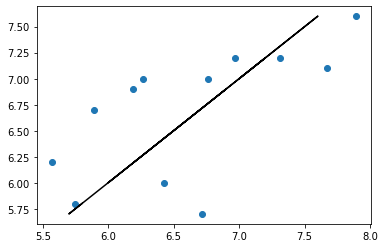

In [53]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

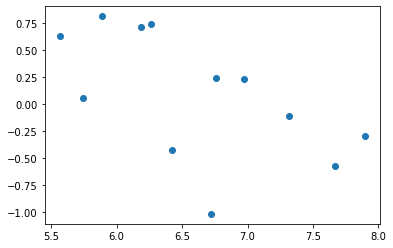

In [54]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [55]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(20)

,Feature,Coefficient
301,documentary Jean-Luc Godard,0.25609
135,log_rating_count^2,0.24083
256,cinematographer_OTHER Jean-Claude Brialy,-0.14039
60,duration log_rating_count,0.11061
62,duration cinematographer_Fabrice Aragno,-0.08664
89,rating_count cinematographer_Jean-Luc Godard,-0.08525
110,log_year^2,-0.07147
347,Anna Karina Jean-Pierre Léaud,-0.06842
389,Jean-Pierre Léaud Claude Brasseur,-0.06535
66,duration cinematographer_Raoul Coutard,0.06522


In [56]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.4864449873383228,
 'coefficients':                                       Feature  Coefficient
 301               documentary Jean-Luc Godard      0.25609
 135                        log_rating_count^2      0.24083
 256  cinematographer_OTHER Jean-Claude Brialy     -0.14039
 60                  duration log_rating_count      0.11061
 62    duration cinematographer_Fabrice Aragno     -0.08664
 ..                                        ...          ...
 156       log_rating_count Jean-Pierre Cassel      0.00000
 155           log_rating_count Myriem Roussel     -0.00000
 154             log_rating_count Juliet Berto     -0.00000
 153        log_rating_count André S. Labarthe      0.00000
 434                         Claude Brasseur^2     -0.00000
 
 [435 rows x 2 columns]}

In [57]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc_poly_' + director + '.pickle'
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

## C. Lasso and Ridge regression on all features except rating count

### Rerun the model without using `rating_count`

In [58]:
X_tr_no_rc = X_train_val_combo.drop(columns = ['rating_count', 'log_rating_count'])

In [59]:
X_te_no_rc = X_test_combo.drop(columns = ['rating_count', 'log_rating_count'])

In [60]:
#X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
#X_tr.head()

In [61]:
#X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [62]:
#X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [63]:
#X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [64]:
X_tr_no_rc_columns = X_tr_no_rc.columns
poly = PolynomialFeatures(degree=2)

X_tr_no_rc_poly =  poly.fit_transform(X_tr_no_rc )
X_te_no_rc_poly = poly.transform(X_te_no_rc)

X_tr_no_rc_poly_columns = poly.get_feature_names(X_tr_no_rc_columns)

In [65]:
## Scale the data as before
std = StandardScaler()
std.fit(X_tr_no_rc_poly)
## Scale the Predictors on both the train and test set
X_tr_no_rc_poly_st = std.transform(X_tr_no_rc_poly)
X_te_no_rc_poly_st = std.transform(X_te_no_rc_poly)

In [66]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc_poly_st, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017364121907663677, tolerance: 0.0016912972972972975
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017006820314626747, tolerance: 0.0016912972972972975
  model = cd_fast.enet_coordinate_descent(


0.02052637752709252

In [67]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc_poly_columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)



In [68]:
len(coefficients_df)
#lasso_model.coef_

378

In [69]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc_poly_st)

In [70]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5071631852737094

In [71]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.3085693122176747

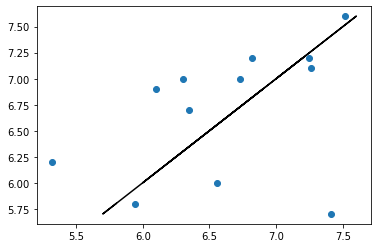

In [72]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')
#plt.plot( x_te_no_rc, y_test, c='k')

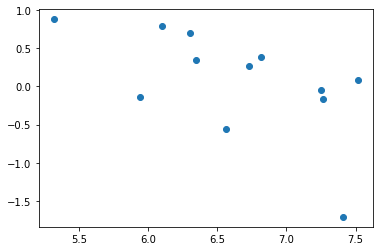

In [73]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)



In [74]:
coefficients_df.head(30)

,Feature,Coefficient
60,duration cinematographer_Raoul Coutard,0.25015
244,documentary Jean-Luc Godard,0.24709
197,cinematographer_OTHER Jean-Pierre Léaud,0.12178
219,cinematographer_Raoul Coutard André S. Labarthe,0.09034
76,duration Georges Staquet,0.07916
53,duration^2,0.06943
72,duration André S. Labarthe,0.03737
82,log_year cinematographer_Julien Hirsch,0.02545
347,Jean-Claude Brialy Jean-Pierre Cassel,0.02446
75,duration Jean-Pierre Cassel,0.01909


In [75]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5071631852737094,
 'coefficients':                                              Feature  Coefficient
 60            duration cinematographer_Raoul Coutard      0.25015
 244                      documentary Jean-Luc Godard      0.24709
 197          cinematographer_OTHER Jean-Pierre Léaud      0.12178
 219  cinematographer_Raoul Coutard André S. Labarthe      0.09034
 76                          duration Georges Staquet      0.07916
 ..                                               ...          ...
 221     cinematographer_Raoul Coutard Myriem Roussel     -0.06131
 290                    Anna Karina Jean-Pierre Léaud     -0.08827
 332                Jean-Pierre Léaud Claude Brasseur     -0.11701
 57          duration cinematographer_Jean-Luc Godard     -0.14147
 199         cinematographer_OTHER Jean-Claude Brialy     -0.17057
 
 [

In [76]:
LCVM_no_rc_filename = 'Lasso_CV_model_no_rc_poly_' + director
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [77]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


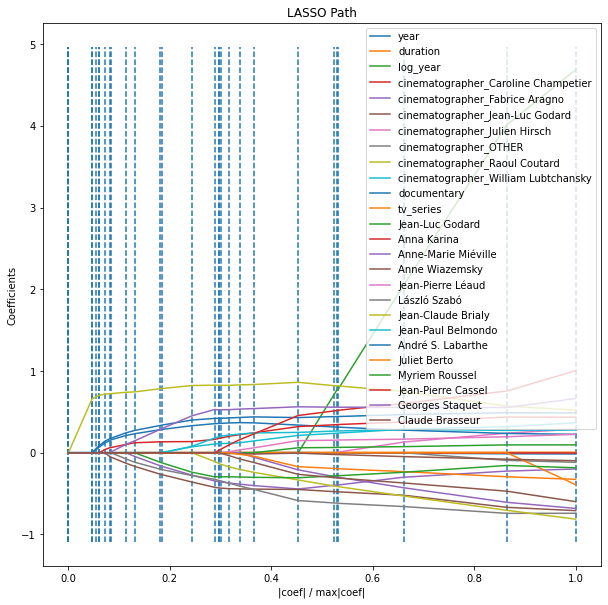

In [78]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [79]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc_poly_st, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [80]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc_poly_columns, ridge_model.coef_))

coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

,Feature,Coefficient
244,documentary Jean-Luc Godard,0.04163
60,duration cinematographer_Raoul Coutard,0.02998
9,cinematographer_Raoul Coutard,0.02785
207,cinematographer_Raoul Coutard^2,0.02785
84,log_year cinematographer_Raoul Coutard,0.02784
...,...,...
200,cinematographer_OTHER Jean-Paul Belmondo,0.00000
208,cinematographer_Raoul Coutard cinematographer_...,0.00000
209,cinematographer_Raoul Coutard documentary,0.00000
210,cinematographer_Raoul Coutard tv_series,0.00000


In [81]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc_poly_st)

In [82]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.4766838992510111

In [83]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.006916333978310485

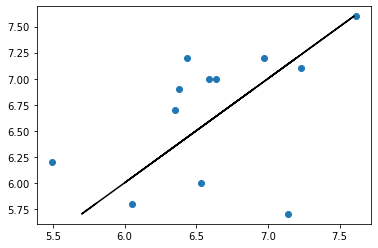

In [84]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

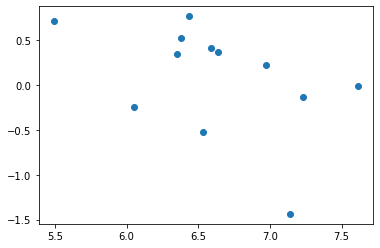

In [85]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)


In [86]:
coefficients_df.head()

,Feature,Coefficient
244,documentary Jean-Luc Godard,0.04163
60,duration cinematographer_Raoul Coutard,0.02998
9,cinematographer_Raoul Coutard,0.02785
207,cinematographer_Raoul Coutard^2,0.02785
84,log_year cinematographer_Raoul Coutard,0.02784


In [87]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.4766838992510111,
 'coefficients':                                                Feature  Coefficient
 244                        documentary Jean-Luc Godard      0.04163
 60              duration cinematographer_Raoul Coutard      0.02998
 9                        cinematographer_Raoul Coutard      0.02785
 207                    cinematographer_Raoul Coutard^2      0.02785
 84              log_year cinematographer_Raoul Coutard      0.02784
 ..                                                 ...          ...
 200           cinematographer_OTHER Jean-Paul Belmondo      0.00000
 208  cinematographer_Raoul Coutard cinematographer_...      0.00000
 209          cinematographer_Raoul Coutard documentary      0.00000
 210            cinematographer_Raoul Coutard tv_series      0.00000
 189  cinematographer_OTHER cinematographer_Raoul

In [88]:
RCVM_no_rc_filename = 'Ridge_CV_model_no_rc_poly_' + director +'.pickle'
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

## D. Lasso and Ridge regression on all features except rating count but with also `budget` added as a feature

### Including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [89]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [90]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [91]:
analysis_columns 

['title',
 'year',
 'duration',
 'budget',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

In [92]:
films_and_features_to_analyze_df = films_to_analyze_financial_df[analysis_columns]

In [93]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [94]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, `year` and `budget` etc

In [95]:
films_and_features_to_analyze_df.columns

Index(['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'Jean-Luc Godard', 'Anna Karina',
       'Anne-Marie Miéville', 'Anne Wiazemsky', 'Jean-Pierre Léaud',
       'László Szabó', 'Jean-Claude Brialy', 'Jean-Paul Belmondo',
       'André S. Labarthe', 'Juliet Berto', 'Myriem Roussel',
       'Jean-Pierre Cassel', 'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [96]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:7], *films_and_features_to_analyze_df.columns[8:]]

In [97]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [98]:
X

,year,duration,budget,cinematographer,documentary,tv_series,Jean-Luc Godard,Anna Karina,Anne-Marie Miéville,Anne Wiazemsky,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
53,"1,987.00000",90.00000,"2,000,000.00000",OTHER,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
103,"1,966.00000",90.00000,"50,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
106,"1,965.00000",110.00000,"300,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
108,"1,965.00000",99.00000,"220,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
112,"1,964.00000",95.00000,"120,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
114,"1,963.00000",102.00000,"900,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
117,"1,963.00000",88.00000,"180,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
119,"1,962.00000",85.00000,"64,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
122,"1,961.00000",84.00000,"160,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
125,"1,960.00000",90.00000,"400,000.00000",Raoul Coutard,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [99]:
y.isnull().values.any()

False

In [100]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [101]:
# X_train_val

## Preprocessing


### Categorical Variable Preprocessing

#### One-hot-encoding

In [102]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [103]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [104]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_OTHER', 'cinematographer_Raoul Coutard'],
      dtype=object)

In [105]:
cat_ohe.shape[0]

8

In [106]:
X_train_val_cat_ohe.shape[0]

8

In [107]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_OTHER,cinematographer_Raoul Coutard
114,0.00000,1.00000
53,1.00000,0.00000
119,0.00000,1.00000
106,0.00000,1.00000
125,0.00000,1.00000


In [108]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [109]:
cont_column_names = ['year', 'duration', 'budget']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()

,year,duration,budget
114,"1,963.00000",102.00000,"900,000.00000"
53,"1,987.00000",90.00000,"2,000,000.00000"
119,"1,962.00000",85.00000,"64,000.00000"
106,"1,965.00000",110.00000,"300,000.00000"
125,"1,960.00000",90.00000,"400,000.00000"


In [110]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
#X_train_val_cont['budget_sq'] = X_train_val_cont.budget**2
#X_train_val_cont['budget_per_year'] = X_train_val_cont.budget/X_train_val_cont.year


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_budget']         = np.log(X_test_cont.budget)
#X_test_cont['budget_sq']  =  X_test_cont.budget**2
#X_test_cont['budget_per_year']  =   X_test_cont.budget/X_test_cont.year

<ipython-input-110-bf549d7df226>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-110-bf549d7df226>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
<ipython-input-110-bf549d7df226>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [111]:
X_test_cont.shape[0]

2

#### Concatenate columns

In [112]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [113]:
X_test_cat_df.isnull().values.any()

False

In [114]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [115]:
X_test_cat_df.shape

(2, 16)

In [116]:
X_train_val_combo.isnull().values.any()

False

In [117]:
X_test_combo.isnull().values.any()

False

In [118]:
X_test_combo

,year,duration,budget,log_year,log_budget,cinematographer_OTHER,cinematographer_Raoul Coutard,documentary,tv_series,Jean-Luc Godard,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
0,"1,961.00000",84.00000,"160,000.00000",7.58121,11.98293,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"1,966.00000",90.00000,"50,000.00000",7.58376,10.81978,0.00000,1.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [119]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'budget', 'log_year', 'log_budget',
       'cinematographer_OTHER', 'cinematographer_Raoul Coutard', 'documentary',
       'tv_series', 'Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto', 'Myriem Roussel', 'Jean-Pierre Cassel',
       'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

### Train vs. val split



In [120]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43) #43

### Lasso CV

In [121]:
X_train_val_combo_columns = X_train_val_combo.columns
poly = PolynomialFeatures(degree=2)

X_train_val_combo_poly =  poly.fit_transform(X_train_val_combo)
X_test_combo_poly = poly.transform(X_test_combo)

X_train_val_combo_poly_columns = poly.get_feature_names(X_train_val_combo_columns)

In [122]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo_poly)
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo_poly)
X_te = std.transform(X_test_combo_poly)

In [123]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,1000)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673602e-02,
       1.11698682e-02, 1.12733256e-02, 1.13777413e-02, 1.14831241e-02,
       1.15894830e-02, 1.16968270e-02, 1.18051653e-02, 1.19145070e-02,
       1.20248614e-02, 1.21362380e-0...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02]),
        cv=5)

In [124]:
# This is the best alpha value it found 
lasso_model.alpha_

0.01

In [125]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo_poly_columns, lasso_model.coef_))
coefficients

[('1', 0.0),
 ('year', -0.5026941756353825),
 ('duration', 0.0),
 ('budget', -0.0),
 ('log_year', -0.004356450162128699),
 ('log_budget', -0.0),
 ('cinematographer_OTHER', -0.0),
 ('cinematographer_Raoul Coutard', 0.0),
 ('documentary', 0.0),
 ('tv_series', 0.0),
 ('Jean-Luc Godard', -0.0),
 ('Anna Karina', -0.0),
 ('Anne-Marie Miéville', 0.0),
 ('Anne Wiazemsky', 0.0),
 ('Jean-Pierre Léaud', 0.0),
 ('László Szabó', -0.0),
 ('Jean-Claude Brialy', 0.0),
 ('Jean-Paul Belmondo', 0.0),
 ('André S. Labarthe', 0.0),
 ('Juliet Berto', 0.0),
 ('Myriem Roussel', 0.0),
 ('Jean-Pierre Cassel', 0.0),
 ('Georges Staquet', 0.08107230754359632),
 ('Claude Brasseur', 3.087807787238717e-16),
 ('year^2', -0.021414939237874898),
 ('year duration', 0.0),
 ('year budget', -0.0),
 ('year log_year', -0.0017640576847859377),
 ('year log_budget', -0.0),
 ('year cinematographer_OTHER', -0.0),
 ('year cinematographer_Raoul Coutard', 0.0),
 ('year documentary', 0.0),
 ('year tv_series', 0.0),
 ('year Jean-Luc God

In [126]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [127]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.3951575117761079

In [128]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.37675996661154887

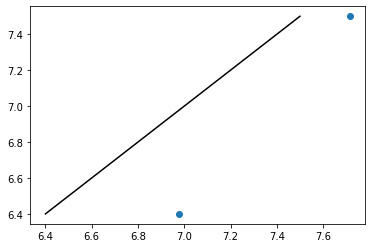

In [129]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

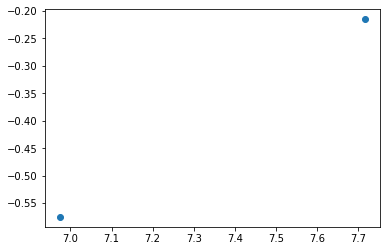

In [130]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [131]:
pd.options.display.float_format = "{:,.5f}".format



In [132]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)
#print(coefficients_df.head(10))

,Feature,Coefficient
1,year,-0.50269
216,Anna Karina André S. Labarthe,0.22317
62,duration Jean-Paul Belmondo,0.10957
73,budget cinematographer_Raoul Coutard,0.10782
22,Georges Staquet,0.08107
215,Anna Karina Jean-Paul Belmondo,0.03317
220,Anna Karina Georges Staquet,0.03100
88,budget Georges Staquet,0.02239
24,year^2,-0.02141
67,duration Georges Staquet,0.02027


In [133]:
Lasso_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.3951575117761079,
 'coefficients':                                   Feature  Coefficient
 1                                    year     -0.50269
 216         Anna Karina André S. Labarthe      0.22317
 62            duration Jean-Paul Belmondo      0.10957
 73   budget cinematographer_Raoul Coutard      0.10782
 22                        Georges Staquet      0.08107
 ..                                    ...          ...
 117        log_budget Anne-Marie Miéville      0.00000
 118             log_budget Anne Wiazemsky      0.00000
 119          log_budget Jean-Pierre Léaud      0.00000
 120               log_budget László Szabó     -0.00000
 299                     Claude Brasseur^2      0.00000
 
 [300 rows x 2 columns]}

In [134]:
LCVM_w_budget_filename = 'Lasso_CV_model_w_budget_poly_' + director + '.pickle'
with open(dir_str + LCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_budget, to_write)

### Ridge regression

In [135]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

0.01

In [136]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo_poly_columns, ridge_model.coef_))


In [137]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [138]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.49421244533065956

In [139]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.17672257148071968

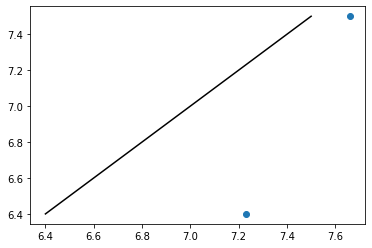

In [140]:

plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

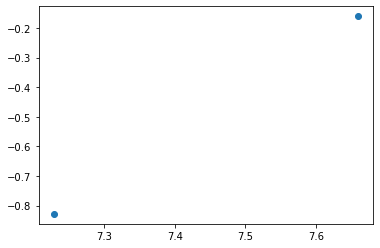

In [141]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [142]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)

,Feature,Coefficient
216,Anna Karina André S. Labarthe,0.06956
73,budget cinematographer_Raoul Coutard,0.04885
215,Anna Karina Jean-Paul Belmondo,0.04767
77,budget Anna Karina,-0.04401
41,year André S. Labarthe,0.03709
104,log_year André S. Labarthe,0.03706
279,André S. Labarthe^2,0.03705
18,André S. Labarthe,0.03705
158,cinematographer_Raoul Coutard André S. Labarthe,0.03705
63,duration André S. Labarthe,0.03506


In [143]:
Ridge_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.49421244533065956,
 'coefficients':                                   Feature  Coefficient
 216         Anna Karina André S. Labarthe      0.06956
 73   budget cinematographer_Raoul Coutard      0.04885
 215        Anna Karina Jean-Paul Belmondo      0.04767
 77                     budget Anna Karina     -0.04401
 41                 year André S. Labarthe      0.03709
 ..                                    ...          ...
 165                 documentary tv_series      0.00000
 166           documentary Jean-Luc Godard      0.00000
 167               documentary Anna Karina      0.00000
 168       documentary Anne-Marie Miéville      0.00000
 0                                       1      0.00000
 
 [300 rows x 2 columns]}

In [144]:
RCVM_w_budget_filename = 'Ridge_CV_model_w_budget_poly_' + director +'.pickle'
with open(dir_str + RCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_w_budget, to_write)

In [145]:
report_filename = 'Lasso_CV_model_w_budget_poly_' + director +'.pickle'
with open(dir_str + report_filename, 'rb') as read_file:
    Lasso_CV_w_budget_poly_report = pickle.load(read_file)

'Lasso_CV_model_w_budget_poly_godard.pickle'